# In this file we generate the dataset for the calibration of the rHeston model with flat forward variance for the pointwise random grids approach
In the forward pass we learn the **mapping** between **rHeston parameters** and the option **implied volatility**, In this case the implied volatility surface is on an adaptive random grid 13(strikes)x11(maturities) a bit larger than the one used for the image based approach.

Below we'll sample appropriate values for the parameters of the rough Heston model, generate the random grids and price all the options.

In [1]:
#Set the directory of stored dataset
import os
import pandas as pd
import numpy as np
import time
from time import perf_counter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.special import gamma
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from scipy.integrate import quad, trapz
os.chdir("C:/Users/pc/Desktop/politecnico/TESI/mio codice/rHeston/random grids")

In [2]:
def generate_rough_heston_parameters(n_samples=16000, seed=42):
    """
    Generate 16000 sets of Rough Heston parameters with Hurst exponent.
    
    Parameters:
    -----------
    n_samples : int
        Number of parameter sets to generate (default: 16000)
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    params_array : numpy.ndarray of shape (n_samples, 6)
        Array containing [ν₀, ρ, γ, θ, κ, H] parameters
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    # Define parameter bounds for Rough Heston model
    param_bounds = {
        'V0': (0.0001, 0.04),      # Initial volatility
        'rho': (-0.7, -0.1),        # Correlation coefficient
        'nu': (0.01, 1.0),          # Volatility of volatility
        'theta': (0.01, 0.2),       # Long-term volatility mean
        'kappa': (1.0, 10.0),       # Mean reversion speed
        'H': (0.025, 0.499)         # Hurst exponent (roughness parameter)
    }
    
    # Initialize array for parameters
    params_array = np.zeros((n_samples, 6), dtype=np.float64)
    rejected_count = 0
    generated_count = 0

    while generated_count < n_samples:
        # Generate candidate parameters
        V0 = np.random.uniform(low=param_bounds['V0'][0], high=param_bounds['V0'][1])
        rho = np.random.uniform(low=param_bounds['rho'][0], high=param_bounds['rho'][1])
        nu = np.random.uniform(low=param_bounds['nu'][0], high=param_bounds['nu'][1])
        theta = np.random.uniform(low=param_bounds['theta'][0], high=param_bounds['theta'][1])
        kappa = np.random.uniform(low=param_bounds['kappa'][0], high=param_bounds['kappa'][1])
        H = np.random.uniform(low=param_bounds['H'][0], high=param_bounds['H'][1])
    
        # Check Feller condition (2κθ > γ²)
        if 2 * kappa * theta > nu**2:
            params_array[generated_count, :] = [V0, rho, nu, theta, kappa,H]
            generated_count += 1
        else:
            rejected_count += 1

    return params_array

# Generate 16000 parameter sets
rheston_params = generate_rough_heston_parameters(16000, seed=42)

# Verify the results
print("Generated parameter sets shape:", rheston_params.shape)
print("Data type:", rheston_params.dtype)
print("\nFirst 5 parameter sets:")
print(rheston_params[:2])

Generated parameter sets shape: (16000, 6)
Data type: float64

First 5 parameter sets:
[[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
 [ 0.03331446 -0.57259653  0.19000672  0.04484686  3.73818019  0.27373455]]


# Let's have a look at the parameters sets and gain some more informations


=== HESTON PARAMETERS ANALYSIS (xx) ===
       ν₀ (initial variance)  ρ (spot-vol correlation)  γ (vol of variance)  \
count             16000.0000                16000.0000           16000.0000   
mean                  0.0200                   -0.4011               0.4470   
std                   0.0115                    0.1724               0.2726   
min                   0.0001                   -0.7000               0.0101   
1%                    0.0005                   -0.6930               0.0189   
5%                    0.0021                   -0.6698               0.0510   
50%                   0.0201                   -0.4010               0.4252   
95%                   0.0380                   -0.1321               0.9166   
99%                   0.0396                   -0.1062               0.9802   
max                   0.0400                   -0.1001               1.0000   

       θ (mean reverting level of variance)  κ (speed of mean reversion)  \
count        

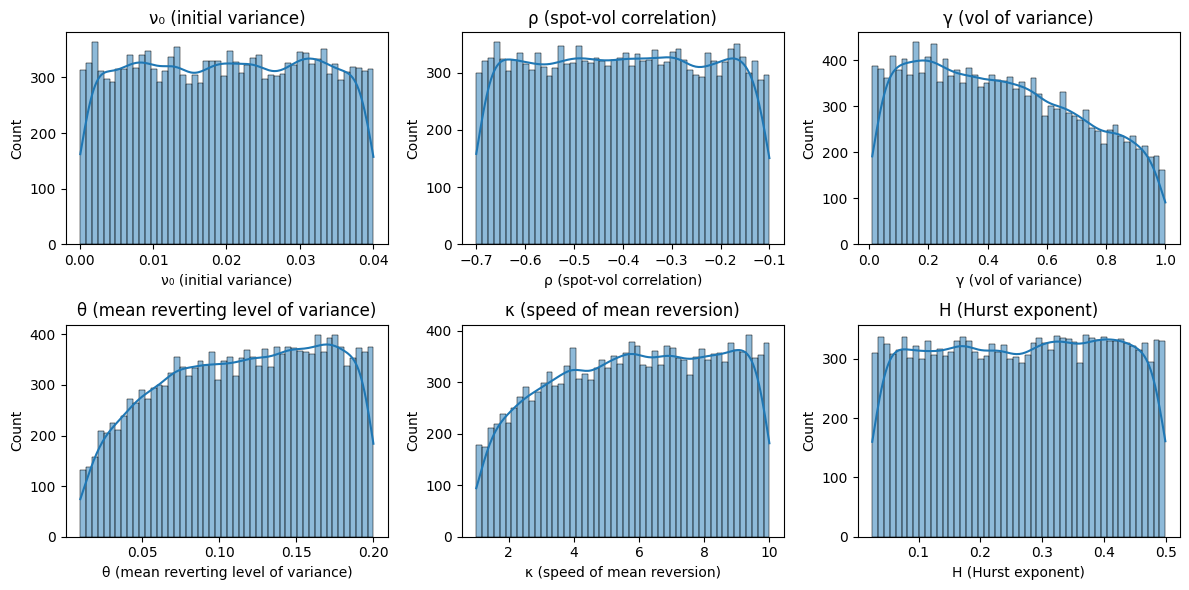

In [3]:
import seaborn as sns

#INPUT (rHESTON PARAMETERS) ANALYSIS 

# Heston parameter names (for clarity)
#v0    ∈ [0.0001, 0.04]        (initial variance)
#rho   ∈ [-0.7, -0.1]          (spot-vol correlation)
#gamma ∈ [0.01, 1.0]           (vol of variance)
#theta ∈ [0.01, 0.2]           (mean reverting level of variance)
#kappa ∈ [1, 10.0]             (speed of mean reversion)
#H     ∈ [0.025, 0.499]        (Hurst exponent)
param_names = [
    'ν₀ (initial variance)',
    'ρ (spot-vol correlation)',
    'γ (vol of variance)',
    'θ (mean reverting level of variance)',
    'κ (speed of mean reversion)',
    'H (Hurst exponent)',
]


# Create DataFrame for statistical analysis
df_xx = pd.DataFrame(rheston_params, columns=param_names)

# Descriptive statistics
print("\n=== HESTON PARAMETERS ANALYSIS (xx) ===")
print(df_xx.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).round(4))

# Validate physical bounds
print("\n=== PHYSICAL BOUNDS ===")
print(f"ν₀:    Min={df_xx.iloc[:,0].min():.4f}, Max={df_xx.iloc[:,0].max():.4f} (Expected: ~[0.0001, 0.04])")
print(f"ρ:   Min={df_xx.iloc[:,1].min():.4f}, Max={df_xx.iloc[:,1].max():.4f} (Expected: ~[-0.7, -0.1])")
print(f"κ: Min={df_xx.iloc[:,4].min():.4f}, Max={df_xx.iloc[:,4].max():.4f} (Expected: ~[1, 10])")

# Plot distributions
plt.figure(figsize=(12, 6))
for i, col in enumerate(df_xx.columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_xx[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Step 1: Data Generation


## **Inputs:** 
###  1. $\nu_{0}$ inital variance
###  2. $\rho$ spot-vol correlation
###  3. $\gamma$ vol of variance
###  4. $\theta$ mean reverting level of variance
###  5. $\kappa$ speed of mean reversion 
###  6. $H$ Hurst exponent
###  7. $K$ option strike price
###  8. $T$ option maturity
    
    
## **Output:**
### Option Implied volatility 

# Generate the random grids
We will associate each parameter set $\theta -> (K_i,T_j)_{i=1,..13}^{j=1,..,11}$ a unique random grid of couples of 11 maturities, each one uniformly sampled from a specified interval, for each maturity we will generate 13 strikes which will depend on the maturity (the longer, the more distanced the strikes)

In [3]:
np.random.seed(42) # Fix seed for reproducibility

def generate_random_rHeston_grids(combined_params, S0=1.0, l=0.55, u=0.3):
    """
    Generates random grids for rHeston parameters following specified rules.
    
    Args:
        combined_params: numpy array of rHeston parameters (16000, 6) [ν₀, ρ, γ, θ, κ, H]
        S0: initial price (default 1.0)
        l: lower bound multiplier (default 0.55)
        u: upper bound multiplier (default 0.3)
        
    Returns:
        numpy array of shape (16000*143, 8) with columns: [ν₀, ρ, γ, θ, κ, H, strike, maturity]
    """
    # Define maturity intervals (11 intervals)
    maturity_intervals = [
        (0.003, 0.03), (0.03, 0.09), (0.09, 0.15), (0.15, 0.3), (0.3, 0.5),
        (0.5, 0.75), (0.75, 1.0), (1.0, 1.25), (1.25, 1.5), (1.5, 2.0), (2.0, 2.5)
    ]
    
    num_samples = combined_params.shape[0]
    num_points_per_sample = 11 * 13  # 11 maturities × 13 strikes each
    total_points = num_samples * num_points_per_sample
    
    # Initialize output array
    output = np.zeros((total_points, 8))
    
    for i in range(num_samples):
        # Get current rHeston parameters
        rheston_param = combined_params[i]
        
        # Generate points for this parameter set
        points = np.zeros((num_points_per_sample, 8))
        
        for j, (t_min, t_max) in enumerate(maturity_intervals):
            # Generate random maturity in this interval
            T = np.random.uniform(t_min, t_max)
            
            # Calculate strike bounds
            sqrt_T = np.sqrt(T)
            K_min = S0 * (1 - l * sqrt_T)
            K_max = S0 * (1 + u * sqrt_T)
            K_mid_low = S0 * (1 - 0.2 * sqrt_T)
            K_mid_high = S0 * (1 + 0.2 * sqrt_T)
            
            # Generate strikes according to specified distribution
            # 4 strikes in [K_min, K_mid_low]
            strikes_low = np.random.uniform(K_min, K_mid_low, 4)
            strikes_low = np.sort(strikes_low)   #sort the strikes
            
            # 7 strikes in [K_mid_low, K_mid_high]
            strikes_mid = np.random.uniform(K_mid_low, K_mid_high, 7)
            strikes_mid = np.sort(strikes_mid)   #sort the strikes

            # 2 strikes in [K_mid_high, K_max]
            strikes_high = np.random.uniform(K_mid_high, K_max, 2)
            strikes_high = np.sort(strikes_high)   #sort the strikes
            # Combine all strikes
            strikes = np.concatenate([strikes_low, strikes_mid, strikes_high])
            
            # Create points for this maturity
            start_idx = j * 13
            end_idx = (j + 1) * 13
            
            # Fill rHeston parameters
            points[start_idx:end_idx, :6] = rheston_param
            
            # Fill strikes
            points[start_idx:end_idx, 6] = strikes
            
            # Fill maturity
            points[start_idx:end_idx, 7] = T
        
        # Add to output array
        output[i*num_points_per_sample:(i+1)*num_points_per_sample] = points
    
    return output

random_grid_data = generate_random_rHeston_grids(rheston_params)
print(f"Random grid dataset shape: {random_grid_data.shape}") # Output shape will be (16000*143, 8) = (2,288,000, 8)

# Print the first two rows as example
print("First two rows of the generated dataset:")
print("Columns: [ν₀, ρ, γ, θ, κ, H, strike, maturity]")
for i in range(2):
    print(f"Row {i+1}: {random_grid_data[i]}")

Random grid dataset shape: (2288000, 8)
First two rows of the generated dataset:
Columns: [ν₀, ρ, γ, θ, κ, H, strike, maturity]
Row 1: [ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414
  0.9432724   0.01311258]
Row 2: [ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414
  0.96101277  0.01311258]


Now we have to compute the EU vanilla call prices through **Lewis method** to have the ground truth of the forward pass, we'll exploit the Adams predictor-corrector scheme in order to solve the fractional Riccati equation and obtain the rough Heston charcateristic function. At the end of the notebook there's the definition of the process and of the class below step by step, as well as the Adams scheme explained, below we leverage a **vectorized** version which allows us to efficiently price all the EU calls in reasonable time.

In [4]:
class roughHeston_vec:
    """
    Vectorized version of roughHeston class (>x1000 faster).
    - rHeston_char_function_batched(a_vec) evaluates the CF for many frequences in a batch.
    - rHeston_Call_vectorized(strikes, upLim, n_u) prices all strikes in one shot through
      Lewis formula with trapz on auniform grid u.
    """
    def __init__(self, nbTimeSteps, rheston_params, T):
        # Time discretisation parameters
        self.T = T
        self.n = nbTimeSteps
        self.dt = self.T / self.n
        self.time_grid = np.linspace(0., T, self.n + 1)

        # Heston model parameters
        self.S0 = 1.0
        self.V0 = rheston_params[0]
        self.rho = rheston_params[1]
        self.nu = rheston_params[2]
        self.theta = rheston_params[3]
        self.kappa = rheston_params[4]
        self.H = rheston_params[5]

        self.alpha = self.H + 0.5

        # Precomputations to speed up pricing
        self.frac = self.dt**self.alpha / gamma(self.alpha + 2.)  # Δ^α / Γ(α+2)
        self.frac2 = self.dt**self.alpha / gamma(self.alpha + 1.) # Δ^α / Γ(α+1)
        self.frac_bar = 1. / gamma(1.-self.alpha) # 1 / Γ(1-α)

        # Build a_ and b_ matrices (same as original)
        self.fill_a()
        self.fill_b()

        # Precompute trapezoidal weights for ∫ h dt (for vectorized integral later)
        w = np.ones(self.n + 1) * self.dt
        w[0] *= 0.5
        w[-1] *= 0.5
        self._trapz_w = w  # shape (n+1,)

        # Precompute weights for fractional integral: (f(t_i)-f(t_{i+1})) * factor
        func = lambda s: (self.T - s)**(1. - self.alpha)
        fgrid = func(self.time_grid)
        self._w_frac = (fgrid[:-1] - fgrid[1:]) * (self.frac_bar / (1. - self.alpha))  # shape (n,)

        # buffer for batched h_hat (avoid repeated allocations)
        self._hbuf = None

    # Fractional Riccati equation (vectorized: accepts array a and array x broadcastable)
    def F(self, a, x):
        # a and x can be arrays with broadcastable shapes
        return -0.5*(a*a + 1j*a) - (self.kappa - 1j*a*self.rho*self.nu)*x + 0.5*self.nu*self.nu*x*x

    def a(self, j, k):
        if j == 0:
            res = ((k - 1)**(self.alpha + 1) - (k - self.alpha - 1)*k**self.alpha)
        elif j == k:
            res = 1.
        else:
            res = ((k + 1 - j)**(self.alpha + 1) + (k - 1 - j)**(self.alpha + 1) - 2 * (k - j)**(self.alpha + 1))
        return self.frac * res

    def fill_a(self):
        self.a_ = np.zeros((self.n + 1, self.n + 1))
        for k in range(1, self.n + 1):
            for j in range(k + 1):
                self.a_[j, k] = self.a(j, k)

    def b(self, j, k):
        return self.frac2 * ((k - j)**self.alpha - (k - j - 1)**self.alpha)

    def fill_b(self):
        self.b_ = np.zeros((self.n, self.n + 1))
        for k in range(1, self.n + 1):
            for j in range(k):
                self.b_[j, k] = self.b(j, k)

    # --- ORIGINAL scalar helpers kept for compatibility/reference ---
    def h_P(self, a, k):  # scalar a
        res = 0
        for j in range(k):
            res += self.b_[j, k] * self.F(a, self.h_hat[j])
        return res

    def sum_a(self, a, k):  # scalar a
        res = 0
        for j in range(k):
            res += self.a_[j, k] * self.F(a, self.h_hat[j])
        return res

    def fill_h(self, a):  # scalar a
        self.h_hat = np.zeros((self.n + 1), dtype=complex)
        for k in range(1, self.n + 1):
            h_P = self.h_P(a, k)
            sum_a = self.sum_a(a, k)
            self.h_hat[k] = sum_a + self.a_[k, k] * self.F(a, h_P)

    # Original scalar CF (kept to compare with original implementation)
    def rHeston_char_function(self, a):
        self.fill_h(a)
        integral = trapz(self.h_hat, self.time_grid)
        func = lambda s: (self.T - s)**(1. - self.alpha)
        y = np.fromiter((((func(self.time_grid[i]) - func(self.time_grid[i+1]))*self.h_hat[i]) for i in range(self.n)), self.h_hat.dtype)
        frac_integral = self.frac_bar * np.sum(y) / (1.-self.alpha)
        return np.exp(self.kappa*self.theta*integral + self.V0*frac_integral)

    # --- VECTORISED CF: evaluates a VECTOR of 'a' (a_vec shape (m,)) ---
    def rHeston_char_function_batched(self, a_vec):
        """
        Evaluates the characteristic function for all the frequences in a_vec (complex array).
        Outputs complex array phi of shape (m,).
        """
        a_vec = np.asarray(a_vec, dtype=np.complex128)
        m = a_vec.size

        # allocate/reuse h buffer: shape (n+1, m)
        if (self._hbuf is None) or (self._hbuf.shape != (self.n + 1, m)):
            self._hbuf = np.zeros((self.n + 1, m), dtype=np.complex128)
        else:
            self._hbuf.fill(0.0)
        h = self._hbuf  # alias

        # time-stepping (k from 1..n), vectorized over m frequencies
        # h[0,:] is zero
        for k in range(1, self.n + 1):
            # Fvals: shape (k, m) = F(a_vec broadcasted over rows, h[0:k, :])
            # We broadcast a_vec into shape (1, m) and let numpy broadcast against (k,m)
            Fvals = self.F(a_vec[None, :], h[0:k, :])  # (k, m)

            # predictor h_P = sum_j b_[j,k] * Fvals[j,:]  -> result shape (m,)
            b_col = self.b_[:k, k].reshape(k, 1)  # (k,1)
            hP = (b_col * Fvals).sum(axis=0)      # (m,)

            # explicit sum_a = sum_j a_[j,k] * Fvals[j,:]
            a_col = self.a_[:k, k].reshape(k, 1)
            sum_a = (a_col * Fvals).sum(axis=0)  # (m,)

            # final step for this k
            h[k, :] = sum_a + self.a_[k, k] * self.F(a_vec, hP)  # (m,)

        # standard integral ∫ h ds for every freq: trapz weights shape (n+1,)
        # integral per frequency -> vector length m
        integral = self._trapz_w.dot(h)   # (m,)  (dot over time axis)

        # fractional integral: h[0:n,:] dot w_frac (n,)
        frac_integral = self._w_frac.dot(h[:-1, :])  # (m,)

        # characteristic phi per frequence
        phi = np.exp(self.kappa * self.theta * integral + self.V0 * frac_integral)
        return phi

    # --- Vectorized Lewis pricing for multiple strikes ---
    def rHeston_Call_vectorized(self, strikes, upLim=5.0, n_u=160):
        """
        Computes call prices for array of strikes (shape (nK,)) using Lewis method + trapz,
        but evaluating CF in batches for all u = [0, upLim] on n_u nodes.
        Outputs array of prices of corresponding strikes.
        """
        strikes = np.atleast_1d(strikes).astype(float)
        k = np.log(strikes / self.S0)  # shape (nK,)

        # griglia u
        u = np.linspace(1e-12, upLim, n_u)  # shape (n_u,)
        a_vec = u - 0.5j                 # shift of Lewis formula

        # CF evaluated in batch on all of a_vec (shape (n_u,))
        phi = self.rHeston_char_function_batched(a_vec)  # (n_u,)

        # build vectorialized integrand:
        # denom (n_u,1), phi[:,None] (n_u,1), phase (n_u, nK)
        denom = (u * u + 0.25)[:, None]         # (n_u, 1)
        phase = np.exp(-1j * np.outer(u, k))    # (n_u, nK)
        integrand = np.real( phase * (phi[:, None] / denom) )  # (n_u, nK)

        # integrate along u (axis 0) for every strike -> shape: (nK,)
        integ = np.trapz(integrand, u, axis=0)

        prices = self.S0 - np.sqrt(self.S0 * strikes) * (integ / np.pi)
        return np.maximum(prices, 1e-8)
    
    # Function to compute implied volatilities
    def implied_volatility_lewis(self, strikes, upLim=15.0, n_u=1024):
        """
        Compute implied volatilities for call options priced via Lewis method.

        Parameters
        ----------
        strikes : array-like
            Strike prices for which to compute implied volatility.
        upLim : float
            Upper integration limit for Lewis formula.
        n_u : int
            Number of integration nodes for Lewis formula.

        Returns
        -------
        ivs : ndarray
            Implied volatilities corresponding to each strike.
        """
        strikes = np.atleast_1d(strikes).astype(float)
        prices = self.rHeston_Call_vectorized(strikes, upLim=upLim, n_u=n_u)
        T = self.T

        ivs = np.zeros_like(strikes)

        def bs_price(K, T, sigma, S0=1.0, r=0.0):
            d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
            d2 = d1 - sigma*np.sqrt(T)
            return S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

        for i, (K, price) in enumerate(zip(strikes, prices)):
            def f(sigma):
                return bs_price(K, T, sigma) - price
            try:
                ivs[i] = brentq(f, 1e-8, 1.0, maxiter=4000)
            except ValueError:
                ivs[i] = np.nan  # if no root found
        return ivs

Below there's a utility function in order to choose the best parameters like: number of time steps, for the computation of the characteristic function, upLim is the Upper integration limit for Lewis formula and the Number of integration nodes for Lewis formula. This is crucial especially for very for T.

In [9]:
def get_rHeston_parameters(T):
    """
    Returns (nSteps, upLim, n_u) for given maturity T.

    Parameters
    ----------
    T : float
        Maturity.

    Returns
    -------
    nSteps : int
        Number of time steps.
    upLim : float
        Upper integration limit for Lewis formula.
    n_u : int
        Number of integration nodes for Lewis formula.
    """

    # --- nSteps ---
    if T < 0.5:
        nSteps = 64
    elif T < 1.7:
        nSteps = 100
    else:
        nSteps = 150

    # --- n_u ---
    if T < 0.04:
        n_u = 8192
    elif T < 0.2:
        n_u = 4096
    else:
        n_u = 1024

    # --- upLim ---
    if T <= 0.015:
        # piecewise linear interpolation for T in [0.003, 0.015]
        T_nodes =  [0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.015]
        up_nodes = [600,   500,   400,   400,   300,   300,   300,   300,  200]

        # extrapolate slightly below first and last if out of bounds
        if T <= T_nodes[0]:
            upLim = up_nodes[0]
        elif T >= T_nodes[-1]:
            upLim = up_nodes[-1]
        else:
            # find segment and interpolate
            for i in range(len(T_nodes) - 1):
                if T_nodes[i] <= T <= T_nodes[i + 1]:
                    t0, t1 = T_nodes[i], T_nodes[i + 1]
                    u0, u1 = up_nodes[i], up_nodes[i + 1]
                    # linear interpolation
                    w = (T - t0) / (t1 - t0)
                    upLim = u0 + w * (u1 - u0)
                    break
    else:
        # region for T > 0.015
        if 0.03 < T < 0.05:
            upLim = 100
        elif 0.05 <= T < 0.2:
            upLim = 50
        elif 0.2 <= T < 0.35:
            upLim = 25
        else:
            upLim = 15

    return nSteps, upLim, n_u

Now we compute the implied volatilities for all the options, thanks to the vectorization we're able to process all the 13 strikes for a given maturity, making this procedure 13 times faster with respect to truly pointwise approaches

In [18]:
from tqdm import tqdm  # For progress bar

def calculate_all_implied_vols(random_grid_data, S0=1.0, r=0.0):
    """
    Calculate implied volatilities for all option points in the random grid dataset.
    
    Args:
        random_grid_data: numpy array of shape (N*143, 8) with columns:
                         [ν₀, ρ, γ, θ, κ, H, strike, maturity]
        S0: initial spot price (default 1.0)
        r: risk-free rate (default 0.0)
        
    Returns:
        Tuple of (implied_vols_array, valid_indices) where:
        - implied_vols_array: array of shape (N*143,) with IVs (NaN where calculation failed)
        - valid_indices: indices of points where IV calculation succeeded
    """
    num_samples = len(random_grid_data) // 143
    implied_vols = np.full(len(random_grid_data), np.nan)
    
    # Process each parameter set (each 143 options)
    for i in tqdm(range(num_samples), desc="Processing parameter sets"):
        # Get current parameter set and all its options
        start_idx = i * 143
        end_idx = (i + 1) * 143
        current_batch = random_grid_data[start_idx:end_idx]
        
        # Extract parameters (same for all 143 options)
        params = current_batch[0, :6]
        
        # Group options by maturity for efficient Lewis pricing
        unique_maturities = np.unique(current_batch[:, 7])
        
        for T in unique_maturities:
            # Get all strikes for this maturity
            maturity_mask = current_batch[:, 7] == T
            strikes = current_batch[maturity_mask, 6]
            nSteps, upLim, n_u = get_rHeston_parameters(T)
            he_vec  = roughHeston_vec(nSteps, params, T) # create rHeston class and compute characteristic function
            
            # Price all options for this maturity with single Lewis call
            try:
                ivs = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u) # Price all options for this maturity
                
                # Store results at the correct positions
                implied_vols[start_idx:end_idx][maturity_mask] = ivs
            except Exception as e:
                print(f"\nError processing parameter set {i+1}, maturity {T:.4f}: {str(e)}")
                continue
    
    # Identify valid results (non-NaN)
    valid_indices = np.where(~np.isnan(implied_vols))[0]
    
    print(f"\nCalculation completed. Success rate: {len(valid_indices)/len(implied_vols):.2%}")
    return implied_vols, valid_indices

implied_vols, valid_idx = calculate_all_implied_vols(random_grid_data)

Processing parameter sets:   0%|          | 8/16000 [00:28<15:37:57,  3.52s/it]C:\Users\pc\AppData\Local\Temp\ipykernel_22324\3552265459.py:52: RuntimeWarning: overflow encountered in multiply
  return -0.5*(a*a + 1j*a) - (self.kappa - 1j*a*self.rho*self.nu)*x + 0.5*self.nu*self.nu*x*x
C:\Users\pc\AppData\Local\Temp\ipykernel_22324\3552265459.py:132: RuntimeWarning: invalid value encountered in multiply
  hP = (b_col * Fvals).sum(axis=0)      # (m,)
C:\Users\pc\AppData\Local\Temp\ipykernel_22324\3552265459.py:136: RuntimeWarning: invalid value encountered in multiply
  sum_a = (a_col * Fvals).sum(axis=0)  # (m,)
C:\Users\pc\AppData\Local\Temp\ipykernel_22324\3552265459.py:139: RuntimeWarning: invalid value encountered in multiply
  h[k, :] = sum_a + self.a_[k, k] * self.F(a_vec, hP)  # (m,)
C:\Users\pc\AppData\Local\Temp\ipykernel_22324\3552265459.py:52: RuntimeWarning: invalid value encountered in multiply
  return -0.5*(a*a + 1j*a) - (self.kappa - 1j*a*self.rho*self.nu)*x + 0.5*self.


Calculation completed. Success rate: 98.04%


In [19]:
# QUICK ANALYISIS OF IMPLIED VOLATILITIES COMPUTATION
failed_mask = np.isnan(implied_vols)
num_failed = failed_mask.sum()

if num_failed > 0:
    failed_points = random_grid_data[failed_mask]
    
    # Get unique parameter sets with at least one failure
    failed_params = np.unique(failed_points[:, :6], axis=0)
    num_failed_paramsets = len(failed_params)
    
    print("\nDiagnostic Summary:")
    print(f"Total failed calculations: {num_failed}")
    print(f"Unique parameter sets with failures: {num_failed_paramsets}")
else:
    print("\nAll calculations succeeded!")


Diagnostic Summary:
Total failed calculations: 44732
Unique parameter sets with failures: 8778


In [20]:
# NEED TO HANDLE FAILURES IN IMPLIED VOLATILITY COMPUTATION, ENSURE DATA QUALITY
# Cut out parameters sets with failures.

def keep_only_perfect_blocks(random_grid_data, implied_vols, points_per_sample=143):
    """
    Strict cleaning that only keeps parameter sets with ALL 143 implied volatilities valid.
    
    Args:
        random_grid_data: (N*143, 8) array of [params, strike, maturity]
        implied_vols: (N*143,) array of implied volatilities
        points_per_sample: Points per parameter set (default 143)
        
    Returns:
        clean_data: (M*143, 8) array with complete blocks only
        clean_ivs: (M*143,) array without any NaNs
        n_dropped: Number of full parameter sets dropped
    """
    n_samples = len(random_grid_data) // points_per_sample
    clean_data = []
    clean_ivs = []
    n_dropped = 0
    
    for i in range(n_samples):
        block_start = i * points_per_sample
        block_end = (i+1) * points_per_sample
        block_ivs = implied_vols[block_start:block_end]
        
        # Keep only if ALL IVs are valid
        if not np.isnan(block_ivs).any():
            clean_data.append(random_grid_data[block_start:block_end])
            clean_ivs.append(block_ivs)
        else:
            n_dropped += 1
    
    # Combine results if we found valid blocks
    if clean_data:
        final_data = np.vstack(clean_data)
        final_ivs = np.concatenate(clean_ivs)
    else:
        final_data = np.empty((0, 8))
        final_ivs = np.empty((0,))
    
    print("\nStrict cleaning results:")
    print(f"Complete blocks kept: {len(clean_data)}/{n_samples}")
    print(f"Blocks dropped: {n_dropped}")
    print(f"Final dataset size: {len(final_ivs)} options ({final_data.shape[0]//points_per_sample} parameter sets)")
    
    return final_data, final_ivs, n_dropped

# Usage example:
clean_data, clean_ivs, n_dropped = keep_only_perfect_blocks(random_grid_data, implied_vols)


Strict cleaning results:
Complete blocks kept: 7222/16000
Blocks dropped: 8778
Final dataset size: 1032746 options (7222 parameter sets)


=== Dataset Integrity Checks ===
NaN in clean_data: False
NaN in clean_ivs: False
IV range: [0.0215, 0.5097]

=== Parameter Set Validation ===
Found 7222 unique parameter sets

=== Option Structure Validation ===
Maturities per set: 11 (expected: 11)
Options per maturity: 13 (expected: 13)

=== First Parameter Set Sample ===
Parameters: [ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
First 5 options:
K=0.9433 | T=0.0131 | IV=0.2571
K=0.9610 | T=0.0131 | IV=0.2194
K=0.9664 | T=0.0131 | IV=0.2057
K=0.9751 | T=0.0131 | IV=0.1860
K=0.9780 | T=0.0131 | IV=0.1791
IV Statistics:
- Total points: 1032746
- Valid IV [0-1]: 1032746 (100.00%)
- Negative IV: 0 (0.00%)
- IV > 1: 0 (0.00%)


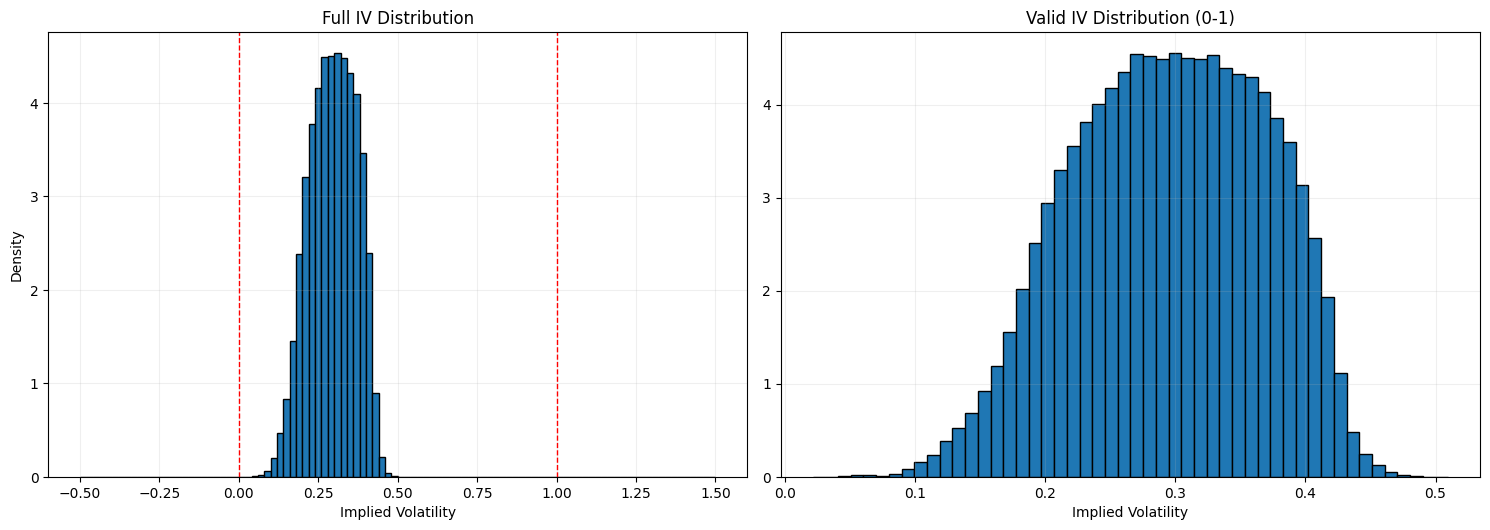

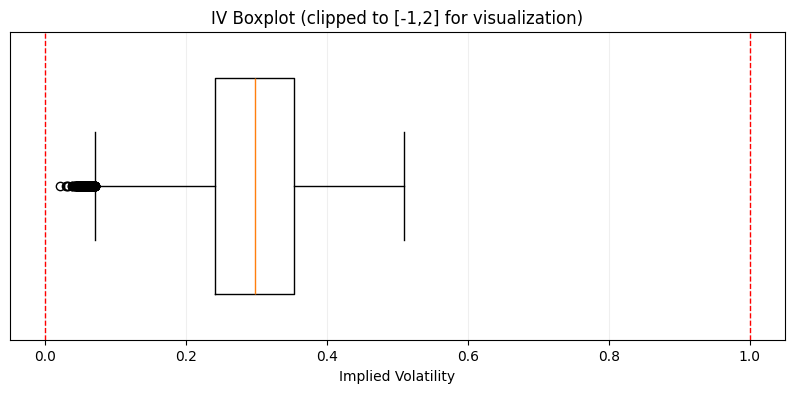

In [21]:
# HAVE MORE INSIGHTS ON THE DATA AND THE DISTRIBUTION OF IMPLIED VOLATILITIES
#================================================================================

def verify_clean_dataset(clean_data, clean_ivs, points_per_sample=143):
    """
    Performs comprehensive validation on cleaned dataset:
    1. Checks for remaining NaN values
    2. Validates implied volatility range (0-1)
    3. Verifies parameter set ordering consistency
    4. Checks maturity/strike structure
    
    Args:
        clean_data: (N*143, 8) array of [params, strike, maturity]
        clean_ivs: (N*143,) array of implied volatilities
        points_per_sample: Points per parameter set (default 143)
    """
    # --- Basic Integrity Checks ---
    print("=== Dataset Integrity Checks ===")
    print(f"NaN in clean_data: {np.isnan(clean_data).any()}")
    print(f"NaN in clean_ivs: {np.isnan(clean_ivs).any()}")
    print(f"IV range: [{clean_ivs.min():.4f}, {clean_ivs.max():.4f}]")
    
    # --- Parameter Set Consistency ---
    print("\n=== Parameter Set Validation ===")
    sample_params = clean_data[::points_per_sample, :6]  # Get first row of each block
    unique_params = np.unique(sample_params, axis=0)
    print(f"Found {len(unique_params)} unique parameter sets")
    
    # --- Strike/Maturity Structure Verification ---
    print("\n=== Option Structure Validation ===")
    first_block = clean_data[:points_per_sample]
    maturities, counts = np.unique(first_block[:,7], return_counts=True)
    print(f"Maturities per set: {len(maturities)} (expected: 11)")
    print(f"Options per maturity: {counts[0]} (expected: 13)")
    
    # --- Sample Data Inspection ---
    print("\n=== First Parameter Set Sample ===")
    print("Parameters:", clean_data[0,:6])
    print("First 5 options:")
    for i in range(5):
        print(f"K={clean_data[i,6]:.4f} | T={clean_data[i,7]:.4f} | IV={clean_ivs[i]:.4f}")

def analyze_iv_distribution(clean_ivs):
    """
    Comprehensive analysis of implied volatility distribution:
    - Statistical summary
    - Visualization of valid/invalid ranges
    - Outlier detection
    
    Args:
        clean_ivs: Array of implied volatilities
    """
    # --- Statistical Analysis ---
    stats = {
        'total': len(clean_ivs),
        'valid': np.sum((clean_ivs >= 0) & (clean_ivs <= 1)),
        'negative': np.sum(clean_ivs < 0),
        'excessive': np.sum(clean_ivs > 1)
    }
    
    print(f"IV Statistics:\n"
          f"- Total points: {stats['total']}\n"
          f"- Valid IV [0-1]: {stats['valid']} ({stats['valid']/stats['total']:.2%})\n"
          f"- Negative IV: {stats['negative']} ({stats['negative']/stats['total']:.2%})\n"
          f"- IV > 1: {stats['excessive']} ({stats['excessive']/stats['total']:.2%})")

    # --- Visualization ---
    plt.figure(figsize=(15,10))
    
    # Main distribution plot
    plt.subplot(2,2,1)
    plt.hist(clean_ivs, bins=100, range=(-0.5,1.5), density=True, edgecolor='k')
    plt.axvline(0, c='r', ls='--', lw=1)
    plt.axvline(1, c='r', ls='--', lw=1)
    plt.title('Full IV Distribution')
    plt.xlabel('Implied Volatility')
    plt.ylabel('Density')
    plt.grid(alpha=0.2)

    # Valid range zoom
    plt.subplot(2,2,2)
    valid_ivs = clean_ivs[(clean_ivs >=0) & (clean_ivs <=1)]
    plt.hist(valid_ivs, bins=50, density=True, edgecolor='k')
    plt.title('Valid IV Distribution (0-1)')
    plt.xlabel('Implied Volatility')
    plt.grid(alpha=0.2)

    # Negative IVs (if any)
    if stats['negative'] > 0:
        plt.subplot(2,2,3)
        plt.hist(clean_ivs[clean_ivs<0], bins=max(5, stats['negative']//10), edgecolor='k')
        plt.title('Negative IV Distribution')
        plt.xlabel('Implied Volatility')
        plt.grid(alpha=0.2)

    # Excessive IVs (if any)
    if stats['excessive'] > 0:
        plt.subplot(2,2,4)
        plt.hist(clean_ivs[clean_ivs>1], bins=max(5, stats['excessive']//10), edgecolor='k')
        plt.title('Excessive IV Distribution (>1)')
        plt.xlabel('Implied Volatility')
        plt.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

    # --- Outlier Analysis ---
    plt.figure(figsize=(10,4))
    boxplot_data = clean_ivs[(clean_ivs >= -1) & (clean_ivs <= 2)]
    plt.boxplot(boxplot_data, vert=False, widths=0.7)
    plt.axvline(0, c='r', ls='--', lw=1)
    plt.axvline(1, c='r', ls='--', lw=1)
    plt.title('IV Boxplot (clipped to [-1,2] for visualization)')
    plt.xlabel('Implied Volatility')
    plt.yticks([])
    plt.grid(alpha=0.2)
    plt.show()

# Example usage
verify_clean_dataset(clean_data, clean_ivs)
analyze_iv_distribution(clean_ivs)

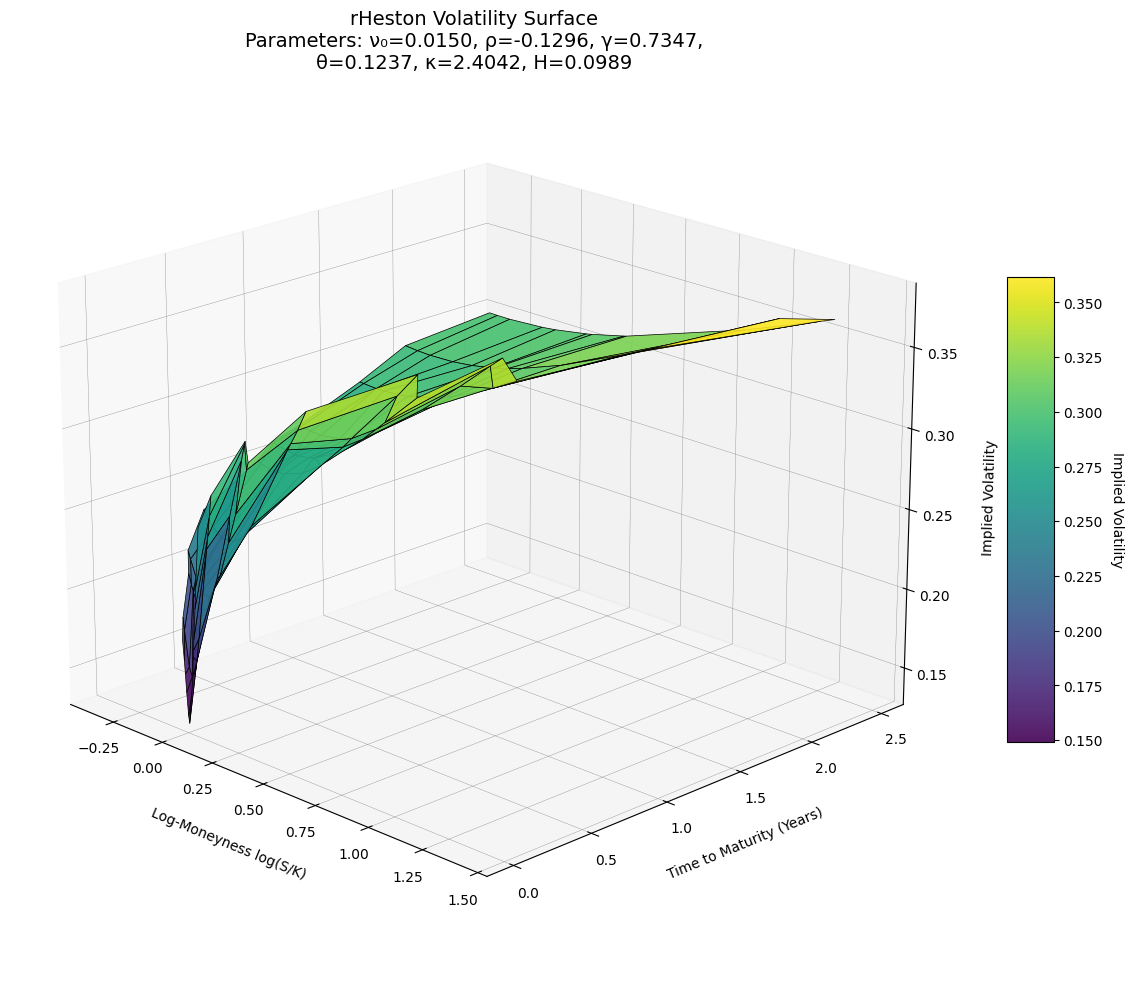

In [22]:
# PLOT ONE IMPLIED VOLATILITY SURFACE
from mpl_toolkits.mplot3d import Axes3D


def plot_rHeston_vol_surface(data, ivs, S0=1.0, param_set_idx=0, points_per_set=143, 
                           use_log_moneyness=True, show_implied_vols=True):
    """
    Plots a 3D volatility surface for a specific rHeston parameter set.
    
    Args:
        data: Full dataset array (N*143,8) with columns [ν₀, ρ, γ, θ, κ, H, strike,maturity]
        ivs: Implied volatilities array (N*143,)
        param_set_idx: Index of parameter set to visualize (default: 0)
        points_per_set: Number of options per parameter set (default: 143)
        use_log_moneyness: Whether to plot log(K/S0) instead of strikes (default: True)
        show_implied_vols: Whether to show IV values on hover (default: True)
    """
    # Extract the specific parameter set's options
    start_idx = param_set_idx * points_per_set
    end_idx = (param_set_idx + 1) * points_per_set
    param_set = data[start_idx:end_idx]
    param_ivs = ivs[start_idx:end_idx]
    
    # Get parameters for title
    params = param_set[0, :6]
    
    # Prepare grid structure (11 maturities × 13 strikes)
    strikes = param_set[:, 6].reshape(11, 13)
    maturities = param_set[:, 7].reshape(11, 13)
    iv_matrix = param_ivs.reshape(11, 13)
    
    # Calculate log-moneyness if requested
    if use_log_moneyness:
        x_axis = np.log(S0/strikes)  # log(S0/K)
        x_label = "Log-Moneyness log(S/K)"
    else:
        x_axis = strikes
        x_label = "Strike Price K"
    
    # Create 3D plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Surface plot
    surf = ax.plot_surface(x_axis, maturities, iv_matrix, 
                          cmap='viridis', edgecolor='k', alpha=0.9,
                          linewidth=0.5, antialiased=True)
    
    # Add colorbar
    cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
    cbar.set_label('Implied Volatility', rotation=270, labelpad=15)
    
    # Customize view angle
    ax.view_init(elev=20, azim=-45)
    
    # Labels and title
    ax.set_xlabel(x_label, labelpad=12)
    ax.set_ylabel('Time to Maturity (Years)', labelpad=12)
    ax.set_zlabel('Implied Volatility', labelpad=12)
    
    title = (f"rHeston Volatility Surface\n"
             f"Parameters: ν₀={params[0]:.4f}, ρ={params[1]:.4f}, γ={params[2]:.4f},\n"
             f"θ={params[3]:.4f}, κ={params[4]:.4f}, H={params[5]:.4f}")
    plt.title(title, y=1.05, fontsize=14)
    
    # Add grid lines
    ax.xaxis._axinfo["grid"].update({"linewidth":0.25, "color":"gray"})
    ax.yaxis._axinfo["grid"].update({"linewidth":0.25, "color":"gray"})
    ax.zaxis._axinfo["grid"].update({"linewidth":0.25, "color":"gray"})
    
    # Add strike values on x-axis (every 2nd strike to avoid clutter)
    if not use_log_moneyness:
        ax.set_xticks(strikes[0, ::2])
        ax.set_xticklabels([f"{k:.2f}" for k in strikes[0, ::2]], rotation=45)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have loaded your data:
# data = np.loadtxt("rBergomiRandomGridsDataset.csv", delimiter=",")
# params = data[:, :5]
# strikes = data[:, 5]
# maturities = data[:, 6]
# ivs = data[:, 7]

# Plot with log-moneyness
plot_rHeston_vol_surface(random_grid_data, implied_vols, param_set_idx=0, use_log_moneyness=True)

In [23]:
# Save the entire dataset (useful)
def save_rHeston_dataset(clean_data , clean_ivs, filename="rHestonflatRandomGridsDataset.csv"):
    """
    Save the complete rHeston dataset (parameters + strikes + maturities + implied vols) to a CSV file.
    
    Args:
        random_grid_data: numpy array of shape (N, 8) with columns [ν₀, ρ, γ, θ, κ, H, strike, maturity]
        implied_vols: numpy array of shape (N,) with implied volatilities
        filename: output CSV filename (default: "rHestonflatRandomGridsDataset.csv")
    
    Returns:
        None (saves a CSV file)
    """
    # Convert to DataFrame for clean CSV export
    df = pd.DataFrame(
        data=np.column_stack((clean_data, clean_ivs)),
        columns=["nu_0", "rho", "gamma", "theta", "kappa", "H", "strike", "maturity", "implied_vol"]
    )
    
    # Optional: Remove rows with NaN implied volatilities
    df_clean = df.dropna(subset=["implied_vol"])
    
    # Save to CSV
    df_clean.to_csv(filename, index=False)
    print(f"Dataset successfully saved to {filename}")
    print(f"Shape: {df_clean.shape}, {len(df) - len(df_clean)} rows removed due to NaN values")

# Example usage:
save_rHeston_dataset(clean_data, clean_ivs)

Dataset successfully saved to rHestonflatRandomGridsDataset.csv
Shape: (1032746, 9), 0 rows removed due to NaN values


# rHeston definition

We introduce the rough Heston (rHeston) price process introduced by [El Euch and Rosenbaum], which we define here by

$$dS_t := S_t \sqrt{V_t} dW_t$$

$$V_t := \nu_0 + \frac{1}{\Gamma(H+\frac{1}{2})} \int_0^t (t-s)^{H-\frac{1}{2}} [\kappa(\theta - V_s) ds + \gamma \sqrt{V_s} dZ_s] , dW_tdZ_t = \rho dt$$

Where the parameters are: $\nu_0>0$, the initial variance, $\rho \in (-\frac{1}{\sqrt{2}}, \frac{1}{\sqrt{2}}] $, the spot-vol correlation, $\gamma>0$, the vol-vol, $\theta>0$, the mean reverting level of variance, $\kappa>0$ the mean reverting speed and $H \in (0, \frac{1}{2}]$, the Hurst exponent which controls the roughness of volatility sample paths.

Below the code for the rough Heston class, it contains the **predictor-corrector** fractional scheme of Adam to solve the fractional Riccati equation and find the rough Heston characteristic function.

Then it's plug into the FFT method to price EU call options.

In [5]:
class roughHeston:
    
    def __init__(self, nbTimeSteps, rheston_params, T):
        # Time discretisation parameters
        self.T = T
        self.n = nbTimeSteps
        self.dt = self.T / self.n
        self.time_grid = np.linspace(0., T, self.n + 1)

        # Heston model paramters
        self.S0 = 1.0
        self.V0 = rheston_params[0]
        self.rho = rheston_params[1]
        self.nu = rheston_params[2]
        self.theta = rheston_params[3]
        self.kappa = rheston_params[4]
        self.H = rheston_params[5] 
        
        self.alpha = self.H + 0.5

        # Precomputations to speed up pricing
        self.frac = self.dt**self.alpha / gamma(self.alpha + 2.)  # => Δᵅ / Γ(α+2)
        self.frac2 = self.dt**self.alpha / gamma(self.alpha + 1.) # => Δᵅ / Γ(α+1)
        self.frac_bar = 1. / gamma(1.-self.alpha) # => 1 / Γ(1-α)
        self.fill_a()
        self.fill_b()

    # Fractional Riccati equation
    def F(self, a, x):
        return -0.5*(a*a + 1j *a) - (self.kappa - 1j*a*self.rho*self.nu)*x + 0.5*self.nu*self.nu*x*x

    # Filling the coefficient a and b which don't depend on the characteristic function (eq 27 of paper)
    #Compute weight aj,k+1 for the corrector
    def a(self, j, k):
        if j == 0:
            res = ((k - 1)**(self.alpha + 1) - (k - self.alpha - 1)*k**self.alpha)
        elif j == k:
            res = 1.
        else:
            res = ((k + 1 - j)**(self.alpha + 1) + (k - 1 - j)**(self.alpha + 1) - 2 * (k - j)**(self.alpha + 1))

        return self.frac*res

    def fill_a(self): #build the triangular matrix of weights
        self.a_ = np.zeros(shape = (self.n + 1, self.n + 1)) # Initialize matrix a for  trapezoidal discretization of the fractional integral scheme 
        for k in range(1, self.n + 1):
            for j in range(k + 1):
                self.a_[j, k] = self.a(j, k)

    def b(self, j, k): #compute weight bj,k+1 for the predictor
        return self.frac2*((k - j)**self.alpha - (k - j - 1)**self.alpha)

    def fill_b(self): #build the triangular matrix of weights
        self.b_ = np.zeros(shape = (self.n, self.n + 1))
        for k in range(1, self.n + 1):
            for j in range(k):
                self.b_[j, k] = self.b(j, k)

    # Computation of two sums used in the scheme
    def h_P(self, a, k): #Computation of the predictor
        res = 0
        for j in range(k):
            res += self.b_[j, k] * self.F(a, self.h_hat[j])
        return res

    def sum_a(self, a, k): #Compute the explicit part of fractional integral (eq 26)
        res = 0
        for j in range(k):
            res += self.a_[j, k] * self.F(a, self.h_hat[j])
        return res

    # Solving function h for each time step (Solve fractional Riccati equation, eq 26)
    def fill_h(self, a):
        self.h_hat = np.zeros((self.n + 1), dtype=complex)
        for k in range(1, self.n + 1):
            h_P = self.h_P(a, k)
            sum_a = self.sum_a(a, k)
            self.h_hat[k] = sum_a + self.a_[k, k]*self.F(a, h_P) #Final explict numerical scheme

    # Characteristic function computation
    def rHeston_char_function(self, a):
        # Filling the h function
        self.fill_h(a) #Solve fractional Riccati, find h_hat

        # Standard integral of the h function over [0,T] int_0^T h_hat(a,s)ds
        integral = trapz(self.h_hat, self.time_grid) 

        # Fractional integral of the h function
        func = lambda s: (self.T - s)**(1. - self.alpha) # kind of primitive of (T-s)^(-alpha)
        y = np.fromiter((((func(self.time_grid[i]) - func(self.time_grid[i+1]))*self.h_hat[i]) for i in range(self.n)), self.h_hat.dtype) # compensate - of primitive*h(t_i), dufference of primitive for integrating fractional kernel
        frac_integral = self.frac_bar * np.sum(y) / (1.-self.alpha) #normalize to get fractional integral

        # Characteristic function
        return np.exp(self.kappa*self.theta*integral + self.V0*frac_integral) #=exp(g1(a,t)+nu_0*g2(a,t)), g1(a,t)=κθ*int_0^t h(a,s)ds (integral), g2(a,t) is the fractional integral of order 1-alpha of h_hat(a,t)
    

    # Pricing with an inverse Fourier transform
    def rHeston_Call(self, K, upLim=5.0):
        k = np.log(K/self.S0)
        func = lambda u: np.real(np.exp(-1j*u*k)*self.rHeston_char_function(u-0.5*1j)) / (u**2 + 0.25)
        integ = quad(func, 0, upLim)
        return self.S0 - np.sqrt(self.S0*K) * integ[0] / np.pi

In [6]:
# rough Heston parameters
rheston_params = np.array([0.02, -0.7, 0.3, 0.02, 3, 0.1]) #[V0, rho, gamma, theta, kappa, H]
strikes = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
T = 1.0
nbTimeSteps, upLim = 100, 5.

# es.: confronta coi tuoi valori e tempi
he = roughHeston(nbTimeSteps, rheston_params, T)
p_quad = []

t0 = time.perf_counter()
for K in strikes:
    p_quad.append(he.rHeston_Call(K, upLim))
t1 = time.perf_counter()
print("quad time:", t1 - t0, "\nprice:", p_quad)

quad time: 23.980508500011638 
price: [0.20286798409873086, 0.1322806173026141, 0.07798903657760059, 0.0383709151003131, 0.011118143646533851]


In [ ]:
class roughHeston_vec:
    """
    Vectorized version of roughHeston class (>x1000 faster).
    - rHeston_char_function_batched(a_vec) evaluates the CF for many frequences in a batch.
    - rHeston_Call_vectorized(strikes, upLim, n_u) prices all strikes in one shot through
      Lewis formula with trapz on auniform grid u.
    """
    def __init__(self, nbTimeSteps, rheston_params, T):
        # Time discretisation parameters
        self.T = T
        self.n = nbTimeSteps
        self.dt = self.T / self.n
        self.time_grid = np.linspace(0., T, self.n + 1)

        # Heston model parameters
        self.S0 = 1.0
        self.V0 = rheston_params[0]
        self.rho = rheston_params[1]
        self.nu = rheston_params[2]
        self.theta = rheston_params[3]
        self.kappa = rheston_params[4]
        self.H = rheston_params[5]

        self.alpha = self.H + 0.5

        # Precomputations to speed up pricing
        self.frac = self.dt**self.alpha / gamma(self.alpha + 2.)  # Δ^α / Γ(α+2)
        self.frac2 = self.dt**self.alpha / gamma(self.alpha + 1.) # Δ^α / Γ(α+1)
        self.frac_bar = 1. / gamma(1.-self.alpha) # 1 / Γ(1-α)

        # Build a_ and b_ matrices (same as original)
        self.fill_a()
        self.fill_b()

        # Precompute trapezoidal weights for ∫ h dt (for vectorized integral later)
        w = np.ones(self.n + 1) * self.dt
        w[0] *= 0.5
        w[-1] *= 0.5
        self._trapz_w = w  # shape (n+1,)

        # Precompute weights for fractional integral: (f(t_i)-f(t_{i+1})) * factor
        func = lambda s: (self.T - s)**(1. - self.alpha)
        fgrid = func(self.time_grid)
        self._w_frac = (fgrid[:-1] - fgrid[1:]) * (self.frac_bar / (1. - self.alpha))  # shape (n,)

        # buffer for batched h_hat (avoid repeated allocations)
        self._hbuf = None

    # Fractional Riccati equation (vectorized: accepts array a and array x broadcastable)
    def F(self, a, x):
        # a and x can be arrays with broadcastable shapes
        return -0.5*(a*a + 1j*a) - (self.kappa - 1j*a*self.rho*self.nu)*x + 0.5*self.nu*self.nu*x*x

    def a(self, j, k):
        if j == 0:
            res = ((k - 1)**(self.alpha + 1) - (k - self.alpha - 1)*k**self.alpha)
        elif j == k:
            res = 1.
        else:
            res = ((k + 1 - j)**(self.alpha + 1) + (k - 1 - j)**(self.alpha + 1) - 2 * (k - j)**(self.alpha + 1))
        return self.frac * res

    def fill_a(self):
        self.a_ = np.zeros((self.n + 1, self.n + 1))
        for k in range(1, self.n + 1):
            for j in range(k + 1):
                self.a_[j, k] = self.a(j, k)

    def b(self, j, k):
        return self.frac2 * ((k - j)**self.alpha - (k - j - 1)**self.alpha)

    def fill_b(self):
        self.b_ = np.zeros((self.n, self.n + 1))
        for k in range(1, self.n + 1):
            for j in range(k):
                self.b_[j, k] = self.b(j, k)

    # --- ORIGINAL scalar helpers kept for compatibility/reference ---
    def h_P(self, a, k):  # scalar a
        res = 0
        for j in range(k):
            res += self.b_[j, k] * self.F(a, self.h_hat[j])
        return res

    def sum_a(self, a, k):  # scalar a
        res = 0
        for j in range(k):
            res += self.a_[j, k] * self.F(a, self.h_hat[j])
        return res

    def fill_h(self, a):  # scalar a
        self.h_hat = np.zeros((self.n + 1), dtype=complex)
        for k in range(1, self.n + 1):
            h_P = self.h_P(a, k)
            sum_a = self.sum_a(a, k)
            self.h_hat[k] = sum_a + self.a_[k, k] * self.F(a, h_P)

    # Original scalar CF (kept to compare with original implementation)
    def rHeston_char_function(self, a):
        self.fill_h(a)
        integral = trapz(self.h_hat, self.time_grid)
        func = lambda s: (self.T - s)**(1. - self.alpha)
        y = np.fromiter((((func(self.time_grid[i]) - func(self.time_grid[i+1]))*self.h_hat[i]) for i in range(self.n)), self.h_hat.dtype)
        frac_integral = self.frac_bar * np.sum(y) / (1.-self.alpha)
        return np.exp(self.kappa*self.theta*integral + self.V0*frac_integral)

    # --- VECTORISED CF: evaluates a VECTOR of 'a' (a_vec shape (m,)) ---
    def rHeston_char_function_batched(self, a_vec):
        """
        Evaluates the characteristic function for all the frequences in a_vec (complex array).
        Outputs complex array phi of shape (m,).
        """
        a_vec = np.asarray(a_vec, dtype=np.complex128)
        m = a_vec.size

        # allocate/reuse h buffer: shape (n+1, m)
        if (self._hbuf is None) or (self._hbuf.shape != (self.n + 1, m)):
            self._hbuf = np.zeros((self.n + 1, m), dtype=np.complex128)
        else:
            self._hbuf.fill(0.0)
        h = self._hbuf  # alias

        # time-stepping (k from 1..n), vectorized over m frequencies
        # h[0,:] is zero
        for k in range(1, self.n + 1):
            # Fvals: shape (k, m) = F(a_vec broadcasted over rows, h[0:k, :])
            # We broadcast a_vec into shape (1, m) and let numpy broadcast against (k,m)
            Fvals = self.F(a_vec[None, :], h[0:k, :])  # (k, m)

            # predictor h_P = sum_j b_[j,k] * Fvals[j,:]  -> result shape (m,)
            b_col = self.b_[:k, k].reshape(k, 1)  # (k,1)
            hP = (b_col * Fvals).sum(axis=0)      # (m,)

            # explicit sum_a = sum_j a_[j,k] * Fvals[j,:]
            a_col = self.a_[:k, k].reshape(k, 1)
            sum_a = (a_col * Fvals).sum(axis=0)  # (m,)

            # final step for this k
            h[k, :] = sum_a + self.a_[k, k] * self.F(a_vec, hP)  # (m,)

        # standard integral ∫ h ds for every freq: trapz weights shape (n+1,)
        # integral per frequency -> vector length m
        integral = self._trapz_w.dot(h)   # (m,)  (dot over time axis)

        # fractional integral: h[0:n,:] dot w_frac (n,)
        frac_integral = self._w_frac.dot(h[:-1, :])  # (m,)

        # characteristic phi per frequence
        phi = np.exp(self.kappa * self.theta * integral + self.V0 * frac_integral)
        return phi

    # --- Vectorized Lewis pricing for multiple strikes ---
    def rHeston_Call_vectorized(self, strikes, upLim=5.0, n_u=160):
        """
        Computes call prices for array of strikes (shape (nK,)) using Lewis method + trapz,
        but evaluating CF in batches for all u = [0, upLim] on n_u nodes.
        Outputs array of prices of corresponding strikes.
        """
        strikes = np.atleast_1d(strikes).astype(float)
        k = np.log(strikes / self.S0)  # shape (nK,)

        # griglia u
        u = np.linspace(1e-12, upLim, n_u)  # shape (n_u,)
        a_vec = u - 0.5j                 # shift of Lewis formula

        # CF evaluated in batch on all of a_vec (shape (n_u,))
        phi = self.rHeston_char_function_batched(a_vec)  # (n_u,)

        # build vectorialized integrand:
        # denom (n_u,1), phi[:,None] (n_u,1), phase (n_u, nK)
        denom = (u * u + 0.25)[:, None]         # (n_u, 1)
        phase = np.exp(-1j * np.outer(u, k))    # (n_u, nK)
        integrand = np.real( phase * (phi[:, None] / denom) )  # (n_u, nK)

        # integrate along u (axis 0) for every strike -> shape: (nK,)
        integ = np.trapz(integrand, u, axis=0)

        prices = self.S0 - np.sqrt(self.S0 * strikes) * (integ / np.pi)
        return np.maximum(prices, 1e-8)

    def rHeston_Call_FFT_CM(self, strikes, Npow=12, A=50, r=0.0):
        """
        Vectorized Carr–Madan FFT for European Call options under rough Heston.
        
        Parameters
        ----------
        strikes : array-like
            Strike prices to price (1D array).
        Npow : int
            Power of two for FFT grid size, N = 2**Npow (default=12).
        A : float
            Upper integration bound in Fourier domain (default=50).
        r : float
            Risk-free interest rate (default=0.0).

        Returns
        -------
        prices : ndarray
            Call prices corresponding to input strikes.
        """
        strikes = np.atleast_1d(strikes).astype(float)
        N = 2 ** Npow
        eta = A / N  # frequency step

        # Frequency grid
        v = np.arange(0, A*(N-1)/N + eta, eta)
        v[0] = 1e-22  # to avoid division by zero

        # Log-strike grid (centered)
        lambda_param = 2 * np.pi / (N * eta)
        k_grid = -lambda_param * N / 2 + lambda_param * np.arange(N)

        # Evaluate characteristic function for v - i
        a_vec = v - 1j
        cf_vals = self.rHeston_char_function_batched(a_vec)

        # Carr–Madan damped transform
        Z_k = np.exp(1j * r * v * self.T) * (cf_vals - 1) / (1j * v * (1j * v + 1))

        # Trapezoidal weights
        w = np.ones(N)
        w[0] = 0.5
        w[-1] = 0.5

        # FFT
        x = w * eta * Z_k * np.exp(1j * np.pi * np.arange(N))
        fft_vals = np.real(np.fft.fft(x) / np.pi)

        # Convert to strike space
        K_grid = self.S0 * np.exp(k_grid)
        C_grid = self.S0 * (fft_vals + np.maximum(1 - np.exp(k_grid - r * self.T), 0))

        # Filter strikes to avoid noisy tails
        mask = (K_grid > 0.4 * self.S0) & (K_grid < 2.0 * self.S0)
        K_filt = K_grid[mask]
        C_filt = C_grid[mask]

        # Interpolation for requested strikes
        interpolator = interp1d(K_filt, C_filt, kind='linear', fill_value='extrapolate')
        prices = interpolator(strikes)

        return np.maximum(prices, 1e-8)

    # Function to compute implied volatilities
    def implied_volatility_lewis(self, strikes, upLim=5.0, n_u=160):
        """
        Compute implied volatilities for call options priced via Lewis method.

        Parameters
        ----------
        strikes : array-like
            Strike prices for which to compute implied volatility.
        upLim : float
            Upper integration limit for Lewis formula.
        n_u : int
            Number of integration nodes for Lewis formula.

        Returns
        -------
        ivs : ndarray
            Implied volatilities corresponding to each strike.
        """
        strikes = np.atleast_1d(strikes).astype(float)
        prices = self.rHeston_Call_vectorized(strikes, upLim=upLim, n_u=n_u)
        T = self.T

        ivs = np.zeros_like(strikes)

        def bs_price(K, T, sigma, S0=1.0, r=0.0):
            d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
            d2 = d1 - sigma*np.sqrt(T)
            return S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

        for i, (K, price) in enumerate(zip(strikes, prices)):
            def f(sigma):
                return bs_price(K, T, sigma) - price
            try:
                ivs[i] = brentq(f, 1e-8, 1.0, maxiter=4000)
            except ValueError:
                ivs[i] = np.nan  # if no root found
        return ivs
    
    # Function to compute implied volatilities
    def implied_volatility_FFT(self, strikes, Npow=12, A=50):
        """
        Compute implied volatilities for call options priced via FFT_CM method.

        Parameters
        ----------
        strikes : array-like
            Strike prices for which to compute implied volatility.
        Npow : int
            Power of two for FFT grid size, N = 2**Npow (default=12).
        A : float
            Upper integration bound in Fourier domain (default=50).

        Returns
        -------
        ivs : ndarray
            Implied volatilities corresponding to each strike.
        """
        strikes = np.atleast_1d(strikes).astype(float)
        prices = self.rHeston_Call_FFT_CM(strikes, Npow=Npow, A=A)
        T = self.T

        ivs = np.zeros_like(strikes)

        def bs_price(K, T, sigma, S0=1.0, r=0.0):
            d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
            d2 = d1 - sigma*np.sqrt(T)
            return S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

        for i, (K, price) in enumerate(zip(strikes, prices)):
            def f(sigma):
                return bs_price(K, T, sigma) - price
            try:
                ivs[i] = brentq(f, 1e-8, 1.0, maxiter=4000)
            except ValueError:
                ivs[i] = np.nan  # if no root found
        return ivs

In [13]:
rheston_params = np.array([0.02, -0.7, 0.3, 0.02, 3, 0.1])  #[V0, rho, gamma, theta, kappa, H]
strikes = np.linspace(0.8, 1.2, 13)
T = 1.0
nbTimeSteps = 100
upLim = 5.0

he_orig = roughHeston(nbTimeSteps, rheston_params, T)   # original class
he_vec  = roughHeston_vec(nbTimeSteps, rheston_params, T)

# 1) timings: original (loop over strikes)
t0 = time.perf_counter()
orig_prices = [he_orig.rHeston_Call(K, upLim=upLim) for K in strikes]
t1 = time.perf_counter()
print("orig loop time:", t1 - t0)

# 2) vectorized (Lewis)
t0 = time.perf_counter()
vec_prices = he_vec.rHeston_Call_vectorized(strikes, upLim=upLim, n_u=160)
t1 = time.perf_counter()
print("vec time:", t1 - t0)

# 3) vectorized (fft)
t0 = time.perf_counter()
prices_fft = he_vec.rHeston_Call_FFT_CM(strikes, Npow=12, A=50)
t1 = time.perf_counter()
print("fft time:", t1 - t0)

print("orig prices:", orig_prices)
print("\nLewis  prices:", vec_prices)
print("\nFFT  prices:", prices_fft)

orig loop time: 63.621061700046994
vec time: 0.01832170004490763
fft time: 0.8505162000656128
orig prices: [0.20286798409873086, 0.17747971046680844, 0.15395326668410647, 0.1322806173026141, 0.11243089961612218, 0.09435489918025353, 0.07798903657760059, 0.06325885569958656, 0.05008202956956942, 0.0383709151003131, 0.028034696413864246, 0.018981159793184044, 0.011118143646533851]

Lewis  prices: [0.20286829 0.17748005 0.15395362 0.13228099 0.11243128 0.09435529
 0.07798943 0.06325926 0.05008243 0.03837132 0.0280351  0.01898156
 0.01111853]

FFT  prices: [0.20679131 0.17697624 0.14791237 0.11943024 0.09218965 0.06759224
 0.04706584 0.03163178 0.02068539 0.01321549 0.00821093 0.00477763
 0.00251455]


[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
0.007
Lewis time: 0.8448480002116412

FFT time: 0.7658992998767644



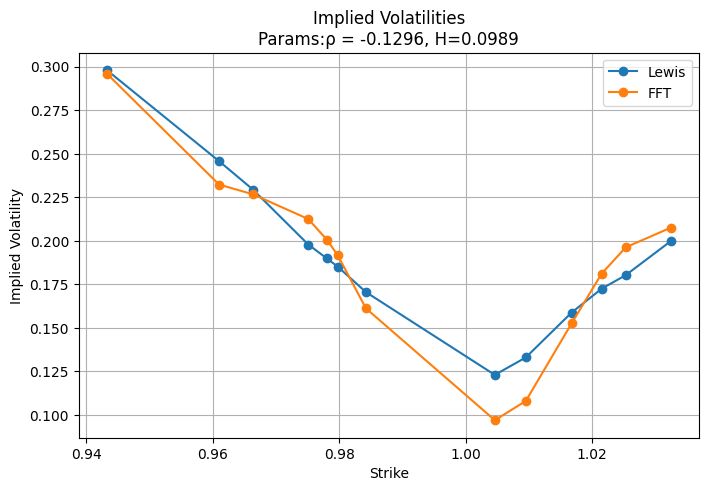

In [10]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[0:13,6]
#params[1] = -0.7
params[1] = -0.12957142
T = 0.007 # random_grid_data[0,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_vec(64, params, T)
print(params)
print(T)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u)
t1 = time.perf_counter()
time_base = t1-t0

print(f"Lewis time: {time_base}\n")

t0 = time.perf_counter()
ivs_fft = he_vec.implied_volatility_FFT(strikes, Npow=13, A=364)
t1 = time.perf_counter()

print(f"FFT time: {t1-t0}\n")

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Lewis')
plt.plot(strikes, ivs_fft, 'o-', label='FFT')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
0.007
Lewis time: 0.49717680003959686

FFT time: 0.8570743999443948



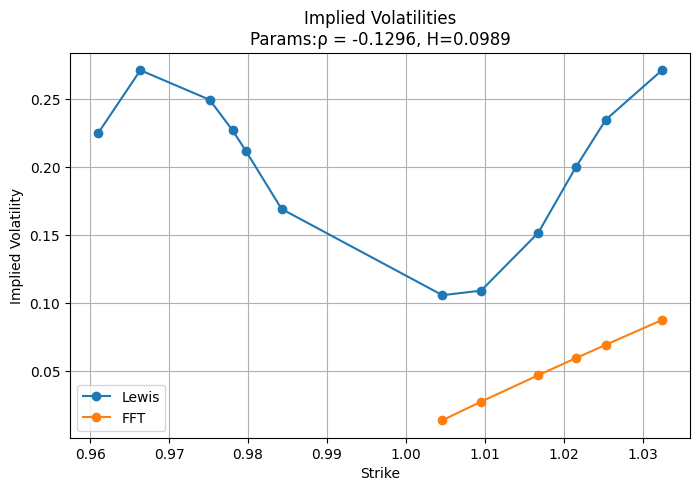

In [26]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[0:13,6]
#params[1] = -0.7
params[1] = -0.12957142
T = 0.007 # random_grid_data[0,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_mod(64, params, T)
print(params)
print(T)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=150, n_u=4096)
t1 = time.perf_counter()
time_base = t1-t0

print(f"Lewis time: {time_base}\n")

t0 = time.perf_counter()
ivs_fft = he_vec.implied_volatility_FFT(strikes, Npow=13, A=100)
t1 = time.perf_counter()

print(f"FFT time: {t1-t0}\n")

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Lewis')
plt.plot(strikes, ivs_fft, 'o-', label='FFT')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

time: 0.4266718000289984

[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
0.04090949803242604
[0.27777089 0.26496002 0.25204398 0.24384894 0.18618985 0.17150751
 0.1714355  0.16635392 0.16223872 0.16028288 0.16582335 0.18776688
 0.19541763]


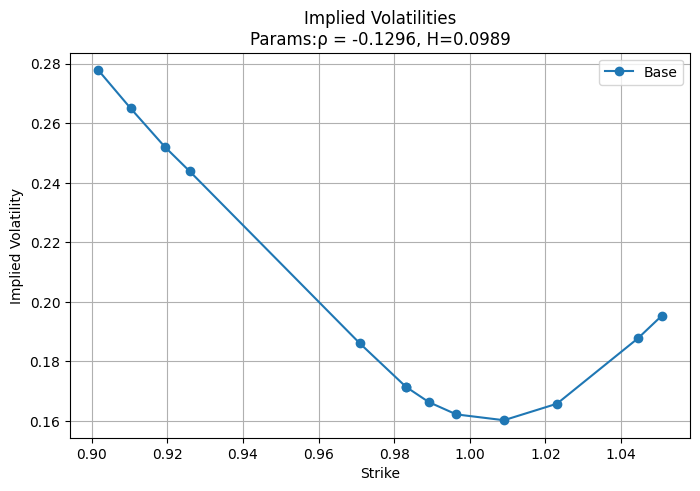

In [202]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[13:26,6]
T = random_grid_data[13,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_vec(n_steps, params, T)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u)
t1 = time.perf_counter()
time_base = t1-t0

print(f"time: {time_base}\n")
print(params)
print(T)
print(ivs_base)
# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Base')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

time: 0.42720559996087104

[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
0.12554487413172255


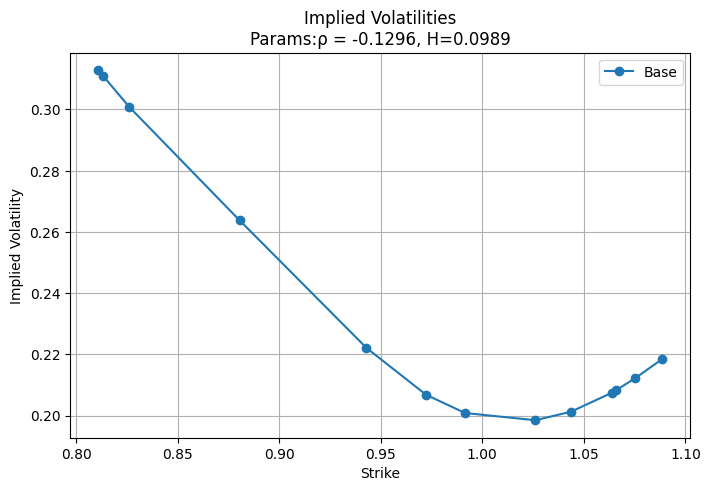

In [203]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[26:39,6]
T = random_grid_data[26,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_vec(n_steps, params, T)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u)
t1 = time.perf_counter()
time_base = t1-t0


print(f"time: {time_base}\n")
print(params)
print(T)

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Base')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

time: 0.4102752000326291

[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
0.15515827816728275


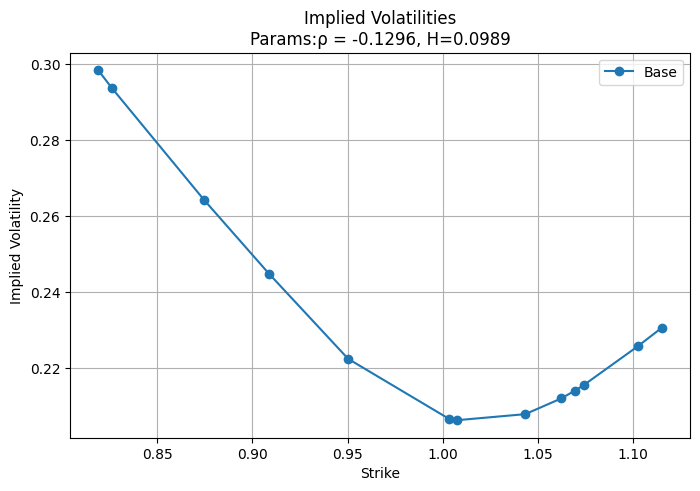

In [204]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[39:52,6]
T = random_grid_data[39,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_vec(n_steps, params, T)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u)
t1 = time.perf_counter()
time_base = t1-t0


print(f"time: {time_base}\n")
print(params)
print(T)

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Base')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

time: 0.084139300044626

[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
0.3176985004103839


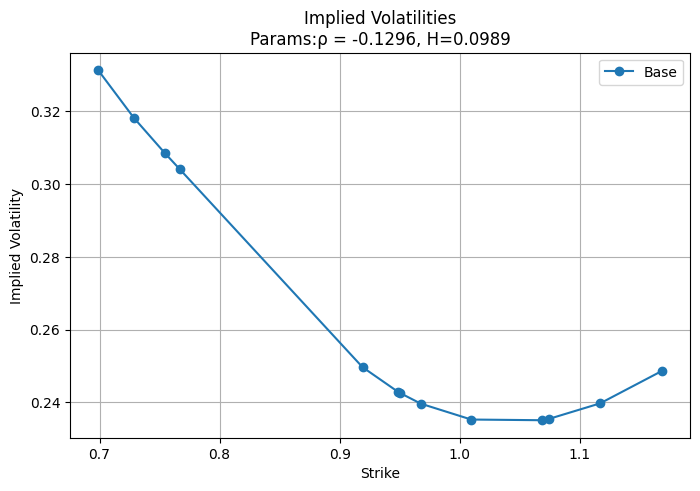

In [205]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[52:65,6]
T = random_grid_data[52,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_vec(n_steps, params, T)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u)
t1 = time.perf_counter()
time_base = t1-t0


print(f"time: {time_base}\n")
print(params)
print(T)

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Base')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

time: 0.22749130002921447

[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
0.6930611923241643


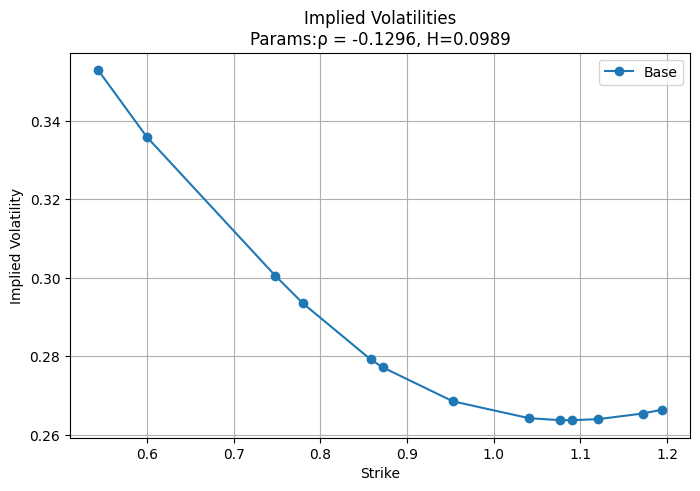

In [206]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[65:78,6]
T = random_grid_data[65,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_vec(n_steps, params, T)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u)
t1 = time.perf_counter()
time_base = t1-t0


print(f"time: {time_base}\n")
print(params)
print(T)

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Base')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

time: 0.2580880999448709

[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
0.8277455804289156
[0.33029455 0.30899683 0.30327682 0.29425893 0.28276202 0.27219722
 0.27184303 0.27092743 0.26985735 0.26978338 0.26978273 0.27243614
 0.27279781]


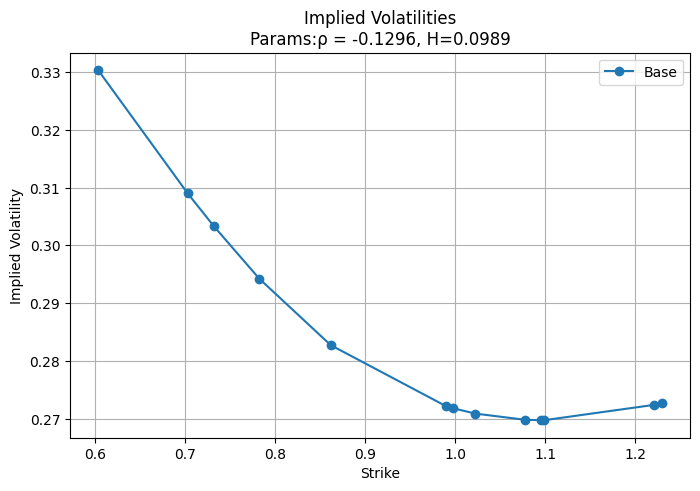

In [207]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[78:91,6]
T = random_grid_data[78,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_vec(n_steps, params, T)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u)
t1 = time.perf_counter()
time_base = t1-t0

print(f"time: {time_base}\n")
print(params)
print(T)
print(ivs_base)

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Base')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

time: 0.25170750002143905

[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
1.0063547816860239
[0.36050929 0.35340482 0.33554087 0.31319688 0.29047376 0.28464093
 0.2839826  0.27982665 0.27812516 0.27625417 0.27655501 0.27755601
 0.27788819]


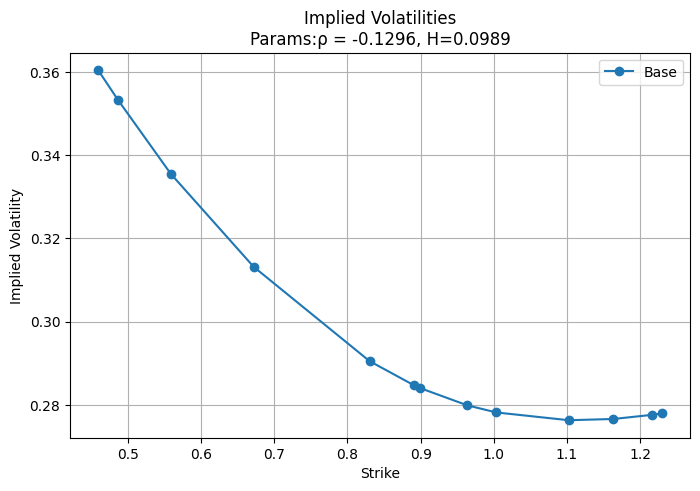

In [208]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[91:104,6]
T = random_grid_data[91,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_vec(n_steps, params, T)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u)
t1 = time.perf_counter()
time_base = t1-t0


print(f"time: {time_base}\n")
print(params)
print(T)
print(ivs_base)

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Base')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

time: 0.2420686000259593

[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
1.4824244130856432
[0.32140298 0.31230766 0.3120933  0.30916319 0.29958354 0.29705085
 0.29353788 0.28976471 0.28812985 0.28814343 0.28814869 0.2887384
 0.2890449 ]


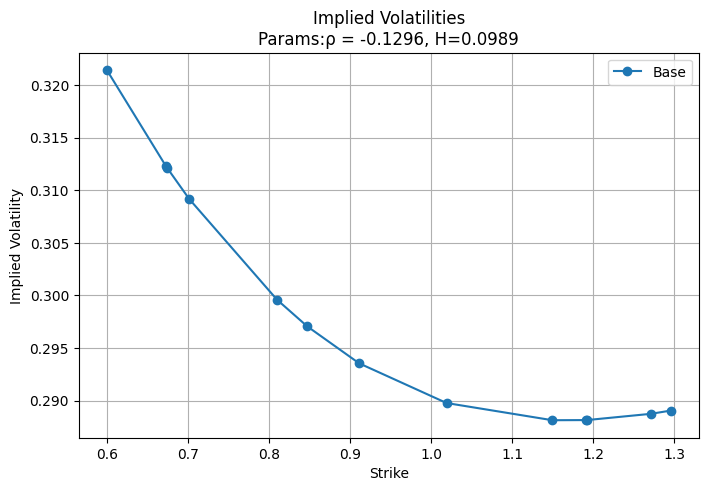

In [209]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[104:117,6]
T = random_grid_data[104,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_vec(n_steps, params, T)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u)
t1 = time.perf_counter()
time_base = t1-t0

print(f"time: {time_base}\n")
print(params)
print(T)
print(ivs_base)

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Base')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

time: 0.4944227999658324

[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
1.9090073829612466
[0.38375417 0.34073471 0.33400351 0.31503951 0.30548297 0.30257386
 0.30026456 0.2999778  0.29718075 0.29565367 0.29518696 0.29554632
 0.29629944]


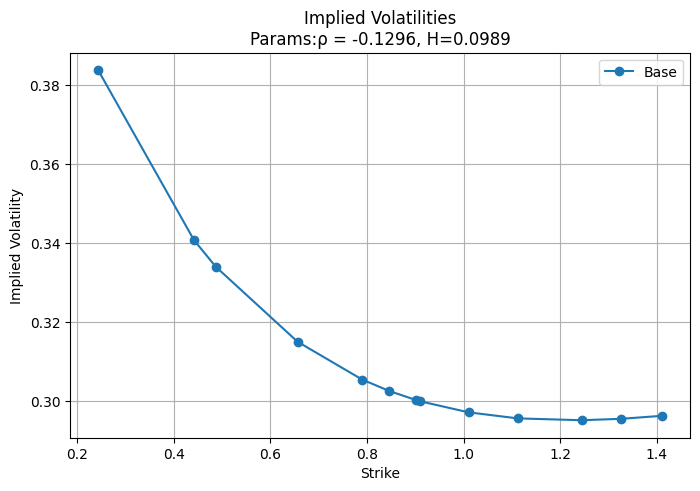

In [210]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[117:130,6]
T = random_grid_data[117,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_vec(n_steps, params, T)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u)
t1 = time.perf_counter()
time_base = t1-t0


print(f"time: {time_base}\n")
print(params)
print(T)
print(ivs_base)

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Base')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

time: 0.534697099996265

[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
2.4812236474710554
[0.36248115 0.35878229 0.35707734 0.33993661 0.3138344  0.3133505
 0.30825629 0.30743415 0.30398258 0.30296783 0.30171409 0.30171801
 0.30185847]


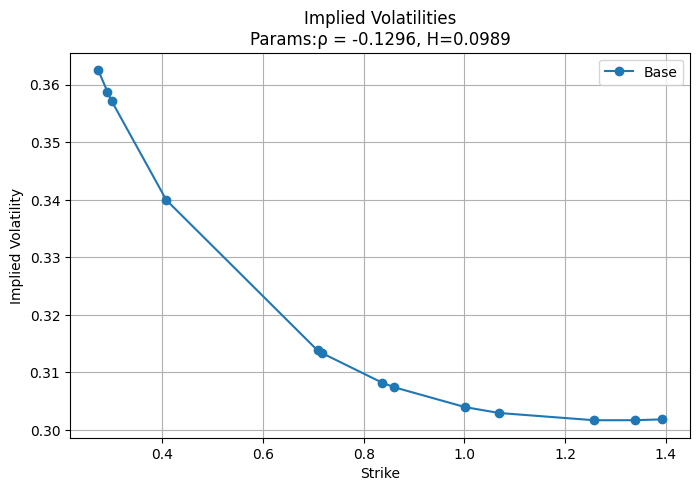

In [213]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[130:143,6]
T = random_grid_data[130,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_vec(n_steps, params, T)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u)
t1 = time.perf_counter()
time_base = t1-t0

print(f"time: {time_base}\n")
print(params)
print(T)
print(ivs_base)

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Base')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

[ 0.01504415 -0.12957142  0.734674    0.12374511  2.40416776  0.0989414 ]
1.0
[0.60315584 0.70262571 0.73193695 0.7821239  0.86156194 0.9898884
 0.99774208 1.02230013 1.07760449 1.09490544 1.09861094 1.22085895
 1.22951956]
Lewis time: 1.5958382999524474



C:\Users\pc\AppData\Local\Temp\ipykernel_18564\4106592060.py:52: RuntimeWarning: overflow encountered in multiply
  return -0.5*(a*a + 1j*a) - (self.kappa - 1j*a*self.rho*self.nu)*x + 0.5*self.nu*self.nu*x*x
C:\Users\pc\AppData\Local\Temp\ipykernel_18564\4106592060.py:139: RuntimeWarning: invalid value encountered in multiply
  h[k, :] = sum_a + self.a_[k, k] * self.F(a_vec, hP)  # (m,)
C:\Users\pc\AppData\Local\Temp\ipykernel_18564\4106592060.py:132: RuntimeWarning: invalid value encountered in multiply
  hP = (b_col * Fvals).sum(axis=0)      # (m,)
C:\Users\pc\AppData\Local\Temp\ipykernel_18564\4106592060.py:136: RuntimeWarning: invalid value encountered in multiply
  sum_a = (a_col * Fvals).sum(axis=0)  # (m,)
C:\Users\pc\AppData\Local\Temp\ipykernel_18564\4106592060.py:52: RuntimeWarning: invalid value encountered in multiply
  return -0.5*(a*a + 1j*a) - (self.kappa - 1j*a*self.rho*self.nu)*x + 0.5*self.nu*self.nu*x*x


FFT time: 2.886507200077176



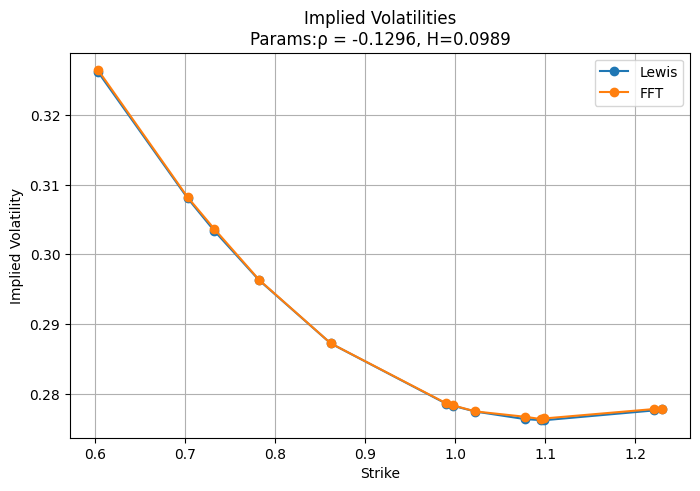

In [ ]:
# Check for short maturity
params = random_grid_data[0,:6]
strikes = random_grid_data[78:91,6]
T = 1.0 # random_grid_data[0,7]
n_steps, upLim, n_u = get_rHeston_parameters(T)
he_vec  = roughHeston_vec(256, params, T)
print(params)
print(T)
print(strikes)

t0 = time.perf_counter()
ivs_base = he_vec.implied_volatility_lewis(strikes, upLim=upLim, n_u=n_u)
t1 = time.perf_counter()
time_base = t1-t0

print(f"Lewis time: {time_base}\n")

t0 = time.perf_counter()
ivs_fft = he_vec.implied_volatility_FFT(strikes, Npow=11, A=120)
t1 = time.perf_counter()

print(f"FFT time: {t1-t0}\n")

# Plot
plt.figure(figsize=(8,5))
plt.plot(strikes, ivs_base, 'o-', label='Lewis')
plt.plot(strikes, ivs_fft, 'o-', label='FFT')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatilities\nParams:ρ = {params[1]:.4f}, H={params[5]:.4f}')
plt.legend()
plt.grid(True)
plt.show()